# OLS regressions - baseline for Capstone analysis
In this notebook, I perform OLS regressions using daily CaBi trips as the dependent variable.

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')
import statsmodels.graphics.gofplots as gofplots
%matplotlib inline

df = pd.read_csv('~/CaBi/final_df.csv')
df.shape

(2739, 803)

### First specification attempt - theory based
A lot of the variation in daily CaBi rides can be explained by weather.
I decided on the following specification based on trial and error and intuition. 
For our ML analysis, we will want to look into ways to perform feature selection algorithmically (I'm looking into this right now).

That said, the variables I've chosen are fairly arbitrary and could probably be improved, but we shouldn't spend a huge amount of time on baseline stuff.

Please feel free to play around with the equations, not just by adding or removing existing features but also by transforming variables (squared terms, log terms, interaction terms)! Patsy makes it easy to do these transformations inside the equation itself.

In [2]:
def fitOLS(equation, cov='nonrobust'):
    '''
    This function uses statsmodels.ols to estimate OLS regressions using R/patsy-style syntax.
    
    Args:
        equation (str): A patsy-style regression equation.
                       e.g. 'cabi_trips ~ apparenttemperaturehigh + daylight_hours + rain'
        cov      (str): A specific covariance matrix type. Default is 'nonrobust'. 
                       HC0-HC3 available for heteroskedasticity-robust standard errors.
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    model = smf.ols('{}'.format(equation), df)
    results = model.fit(cov_type='{}'.format(cov), use_t=True)
    return results

In [3]:
# Fit the model and print results
results = fitOLS('cabi_trips ~ dc_pop + daylight_hours + '
                 'apparenttemperaturehigh + rain + snow + '
                 'nats_games + C(day_of_week)', cov='HC0')
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cabi_trips   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1039.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:08:30   Log-Likelihood:                -24377.
No. Observations:                2739   AIC:                         4.878e+04
Df Residuals:                    2726   BIC:                         4.886e+04
Df Model:                          12                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -5.824e+04    878.770    -66.269      0.000      -6e+04   -5.65e+04
C(day_of_week)[T.1.0]     426.8509    123.087      3.468      0.001     185.497     668.205
C(day_of_week)[T.2.0]     656.5609    125.672      5.224      0.000     410.139     902.983
C(day_of_week)[T.3.0]     846.3974    126.333      6.700      0.000     598.679    1094.116
C(day_of_week)[T.4.0]     758.3391    128.342      5.909      0.000     506.682    1009.996
C(day_of_week)[T.5.0]     828.7916    132.800      6.241      0.000     568.393    1089.190
C(day_of_week)[T.6.0]     485.1161    144.460      3.358      0.001     201.853     768.379
dc_pop                      0.0857      0.001     63.063      0.000       0.083       0.088
daylight_hours            278.7609     27.078     10.295      0.000     225.666     331.856
apparenttemperaturehigh    83.4730      2.821     29.594      0.000      77.942      89.004
rain                    -1363.5428     71.925    -18.958      0.000   -1504.576   -1222.510
snow                    -1488.1867    215.825     -6.895      0.000   -1911.383   -1064.990
nats_games                352.6740     91.615      3.850      0.000     173.032     532.315
==============================================================================
Omnibus:                      116.642   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.382
Skew:                          -0.405   Prob(JB):                     7.42e-37
Kurtosis:                       3.895   Cond. No.                     1.75e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.75e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our results look good. 

The R-squared tells us that about 77% of the variance in cabi_trips is explained by the variance in the explanatory variables.

The low p-values - not literally 0, most packages will report something like <.0001 at minimum - indicate that the results we found are all statistically significant. For our purposes, anything below 0.05 should be considered statistically significant.

Each of the coefficient estimates indicates the average change in cabi_trips associated with a one-unit increase in the explanatory variable, all else held equal. For dummy variables, this can be interpreted as an on-off switch, so on days when it snows, there are 1488 fewer riders on average.

For another example, given two clear Saturdays with identical population, daylight hours, and feels-like temperature, we will expect to see 352 more riders on one day if there happens to be a Nats game.

There are other things to worry about, though. Statistical programming packages often include diagnostic plots by default, but statsmodels doesn't. I explain three of these plots in the next cell.

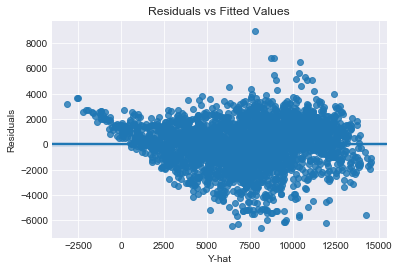

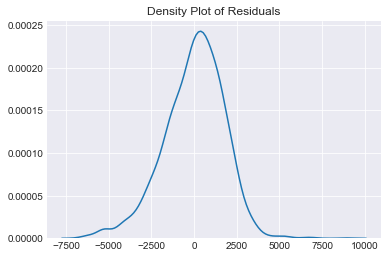

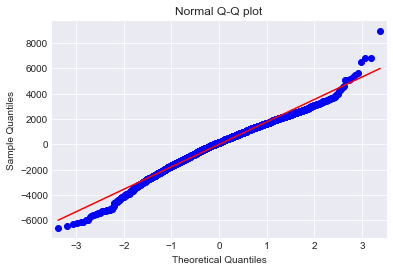

In [4]:
'''Homoskedasticity is when the variance/scatter/spread of the residuals is 
constant for all values of the fitted values. It is an assumption under OLS,
so it can bias our estimates if we don't account for it in some way.

Heteroskedasticity is when the variance of the residuals changes as the fitted values change.
If our residuals were heteroskedastic, we would expect a scatter plot to form a funnel shape,
and a regression line to have a slope.
'''

# Regplot fits a regression line to a scatterplot
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

'''Normality of the residuals with mean 0 is another assumption under OLS.
If residuals are nonnormal and not approximately centered at 0, the model is probably misspecified.
The first chart is a kernel density estimation and the second is a Q-Q plot.

Q-Q plots compare two datasets to see whether or not they come from the same distribution.
If they do, the points should form a straight line.
Here, we have a Normal Q-Q plot, where our residuals are being compared against a normal distribution.
'''

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normal?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

There looks like there probably isn't heteroskedasticity, but there's some weird stuff going on in the portion where Y-hat is negative. I think given our sample size and the significance of our variables, it couldn't hurt to specify heteroskedasticity-robust standard errors (the cov=HC0 argument in fitOLS). In practice I rarely see standard errors that aren't robust to either heteroskedasticity or clustering. (If we wanted to cluster, we would have to choose variables to cluster on, and I haven't looked into that for our data).

The second chart shows that the residuals are pretty close to 0.

The third chart shows that our residuals are close to normal, but at the extreme ends of our distribution we get farther from a normal distribution.

### Second specification attempt - dockless?
Next, I add dless_trips_all to the specification to see if there's any effect.

Its coefficient is not statistically significant, and its confidence interval contains 0. Both of these things suggest that dockless trips don't effect CaBi trips.

                            OLS Regression Results                            
Dep. Variable:             cabi_trips   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     957.6
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:08:31   Log-Likelihood:                -24376.
No. Observations:                2739   AIC:                         4.878e+04
Df Residuals:                    2725   BIC:                         4.886e+04
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -5

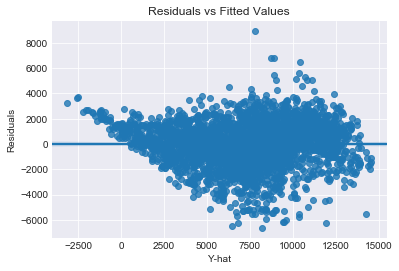

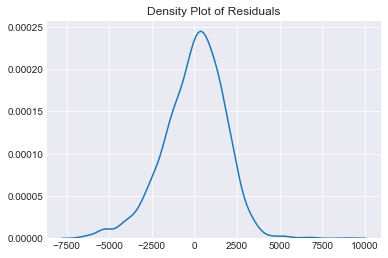

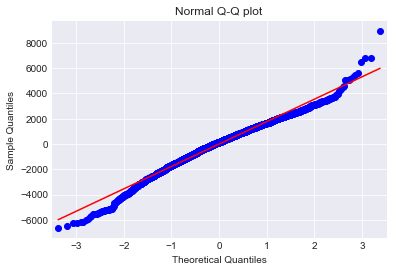

In [5]:
results = fitOLS('cabi_trips ~ dc_pop + daylight_hours +'
                 'apparenttemperaturehigh + rain + snow + '
                 'nats_games + C(day_of_week) + dless_trips_all', cov='HC0')
print(results.summary())

# Heteroskedasticity?
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normality?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

### Third specification attempt - transformations
Next, I try taking the natural log of certain variables. 
When you include a logged variable, its interpretation changes to percentage change instead of unit change. I get into specifics in the cell after the regression results.

Logging variables is also very good for dealing with outliers. OLS is sensitive to outliers - we saw this demonstrated in class when we removed one observation from the IQ ~ TVhours regression. Logging a variable with a long right tail will often make it approximately normal, which is better for OLS.

In [6]:
# While doing this, I ran into errors trying to log cabi_trips because the log of 0 is undefined.
# Ended up having to drop the four observations where cabi_trips==0
df = df[df.cabi_trips != 0]
df.shape

(2735, 803)

In [7]:
import numpy as np

results = fitOLS('np.log(cabi_trips) ~ np.log(dc_pop) + np.log(daylight_hours) + '
                 'np.log(apparenttemperaturehigh) + rain + snow + nats_games + C(day_of_week) + '
                 'dless_trips_all', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(cabi_trips)   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     404.3
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:08:32   Log-Likelihood:                -1137.4
No. Observations:                2735   AIC:                             2303.
Df Residuals:                    2721   BIC:                             2386.
Df Model:                          13                                         
Covariance Type:                  HC0                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -138.3947      2.834    -48.835      0.000    -143.952    -132.838
C(day_of_week)[T.1.0]               0.0868      0.028      3.092      0.002       0.032       0.142
C(day_of_week)[T.2.0]               0.1376      0.025      5.585      0.000       0.089       0.186
C(day_of_week)[T.3.0]               0.1547      0.026      5.905      0.000       0.103       0.206
C(day_of_week)[T.4.0]               0.1427      0.027      5.209      0.000       0.089       0.196
C(day_of_week)[T.5.0]               0.1622      0.025      6.438      0.000       0.113       0.212
C(day_of_week)[T.6.0]               0.0689      0.026      2.604      0.009       0.017       0.121
np.log(dc_pop)                     10.6045      0.211     50.312      0.000      10.191      11.018
np.log(daylight_hours)              0.7910      0.069     11.536      0.000       0.657       0.925
np.log(apparenttemperaturehigh)     0.7323      0.036     20.444      0.000       0.662       0.803
rain                               -0.2165      0.014    -15.083      0.000      -0.245      -0.188
snow                               -0.3640      0.073     -4.953      0.000      -0.508      -0.220
nats_games                          0.0404      0.013      3.000      0.003       0.014       0.067
dless_trips_all                 -3.916e-05   1.49e-05     -2.620      0.009   -6.85e-05   -9.85e-06
==============================================================================
Omnibus:                     1760.498   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50765.498
Skew:                          -2.585   Prob(JB):                         0.00
Kurtosis:                      23.463   Cond. No.                     1.21e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since we have some logged variables, the interpretation of the coefficients changes.

Before, the interpretation of apparenttemperaturehigh's effect on cabi_rides was basically "Holding all else equal, how many more cabi rides should we see if the feels-like temperature is one degree (F) higher?"

Now that both are logged, the coefficient of 0.7323 means "Holding all else equal, if feels-like temperature rises by 1%, we expect there to be a 0.73% increase in CaBi rides." 
Also, a 1% rise in dc population is associated with a >10% increase in CaBi rides! This looks high, but keep in mind that that represents ~7000 people.

I explain the interpretation of the dummy coefficients below.

In [10]:
# When you have a logged dependent variable, be careful with dummies
# The effect is asymmetrical!
# more: https://davegiles.blogspot.com/2011/03/dummies-for-dummies.html
print('If rain switches from 0 to 1, the % impact on cabi_trips is ', 100*(np.exp(-0.2165) - 1))
print('If snow switches from 0 to 1, the % impact on cabi_trips is ', 100*(np.exp(-0.3640) - 1))
print('If rain switches from 1 to 0, the % impact on cabi_trips is ', 100*(np.exp(0.2165) - 1))
print('If snow switches from 1 to 0, the % impact on cabi_trips is ', 100*(np.exp(0.3640) - 1))

If rain switches from 0 to 1, the % impact on cabi_trips is  -19.4667465077
If snow switches from 0 to 1, the % impact on cabi_trips is  -30.5108805257
If rain switches from 1 to 0, the % impact on cabi_trips is  24.1723085354
If snow switches from 1 to 0, the % impact on cabi_trips is  43.9074214158


Also, note that dockless trips are now statistically significant. I believe this is spurious, which is also backed up by the super low, nearly 0 coefficient estimate. Looking at the charts below you can see that things look worse than before. This particular specification is no good.

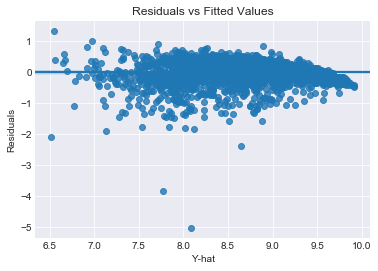

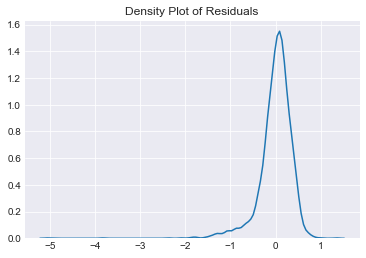

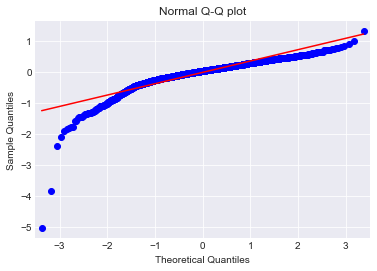

In [8]:
# Heteroskedasticity?
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normality?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()